In [2]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


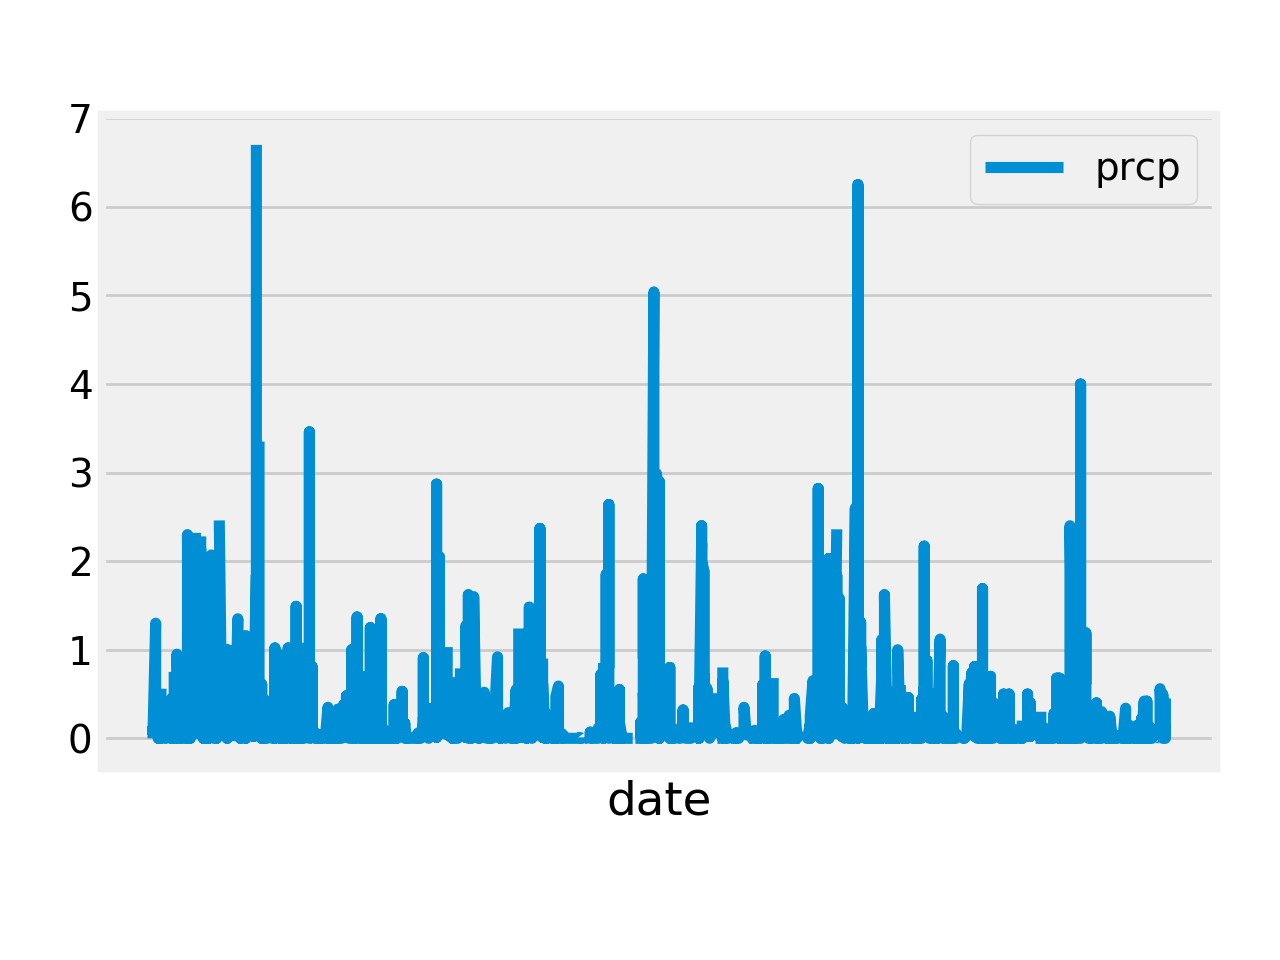

([], <a list of 0 Text xticklabel objects>)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
last_year = dt.datetime.now() - dt.timedelta(days=2*365)
# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(Measurement.date,Measurement.prcp).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_year_data)
df = df.set_index('date')
# Sort the dataframe by date
df = df.sort_index()
df = df.set_index(pd.to_datetime(df.index,format='%Y-%m-%d'))
df = df.loc[df.index>last_year]
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind='line')
# Rotate the xticks for the dates
plt.xticks([],rotation=60)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2125.000000
mean,0.178565
std,0.458468
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [13]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(Measurement.station.desc()).all()

[('USC00519523', 2669),
 ('USC00519397', 2724),
 ('USC00519281', 2772),
 ('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00513117', 2709),
 ('USC00511918', 1979)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519523').group_by(Measurement.station).all()

[(56.0, 85.0, 74.5436493068565)]

<IPython.core.display.Javascript object>


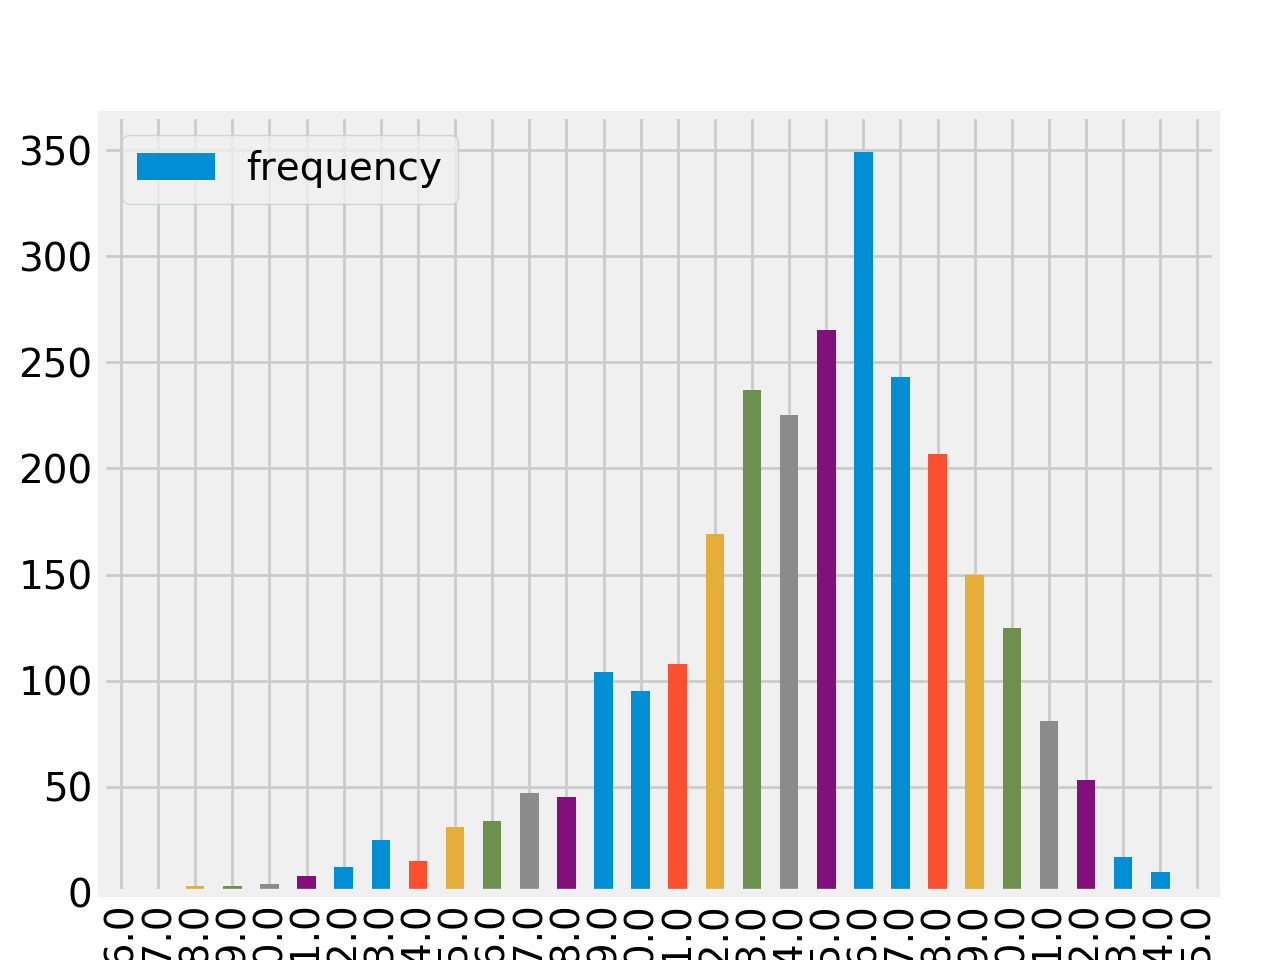

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_tobs = session.query(Measurement.tobs,func.count(Measurement.tobs)).filter(Measurement.station == 'USC00519523').group_by(Measurement.tobs).all()
df2 = pd.DataFrame(max_tobs,columns=['tobs','frequency'])
df2.plot(x='tobs',y='frequency',kind='bar')

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
last_year.strftime('%Y-%m-%d')

'2016-08-05'

In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp = calc_temps(last_year.strftime('%Y-%m-%d'),dt.datetime.now().strftime('%Y-%m-%d'))
temp

[(58.0, 74.77578857630009, 87.0)]

In [19]:
df3=pd.DataFrame(temp, columns=['min','avg','max'])

<IPython.core.display.Javascript object>


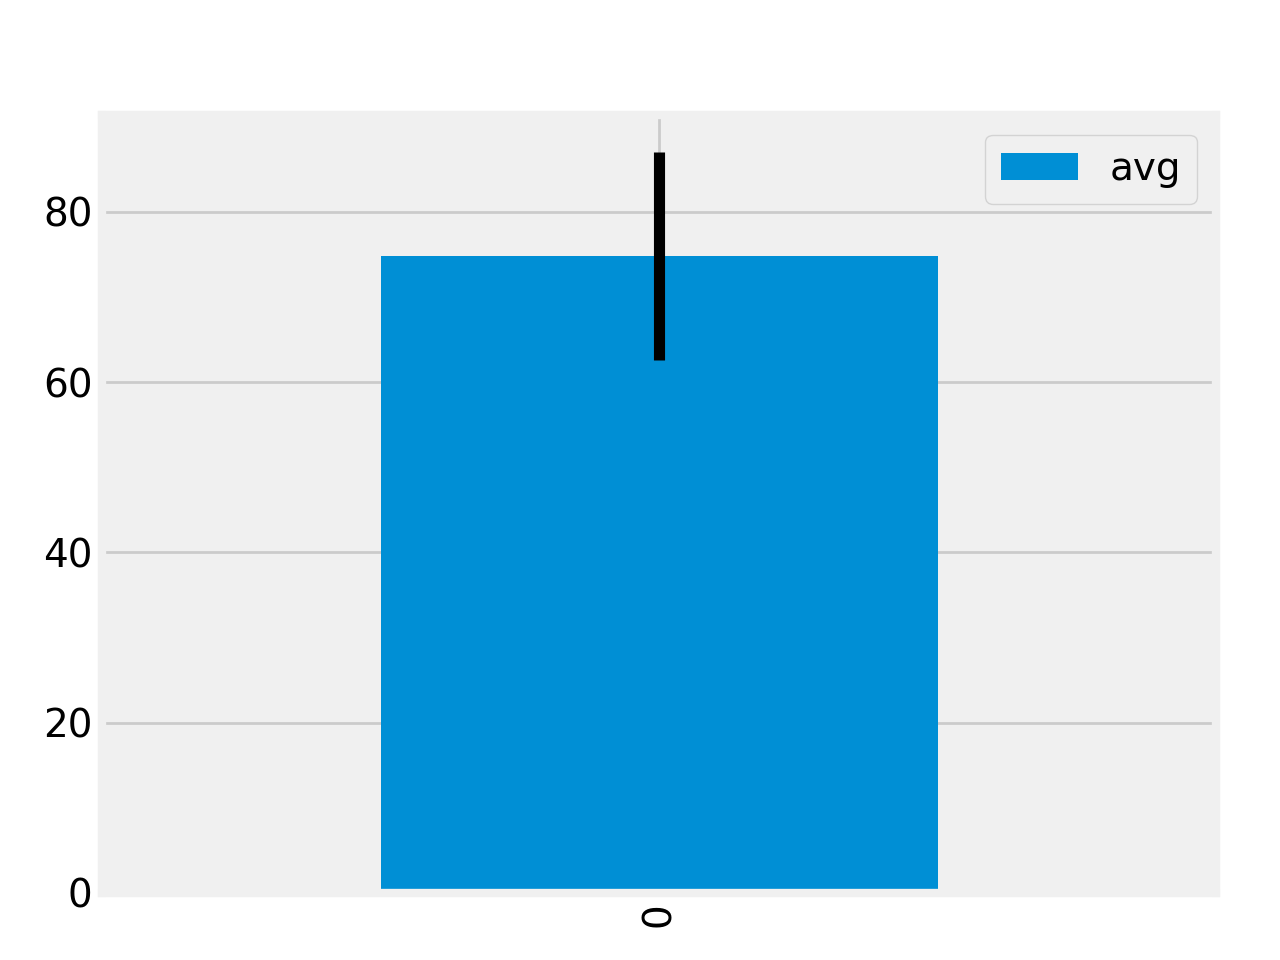

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df3.plot(y='avg',kind='bar',yerr=[[temp[0][2]-temp[0][1]],[temp[0][1]-temp[0][0]]])


In [38]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
df_measure = pd.DataFrame(session.query(Measurement.station,Measurement.date,Measurement.prcp).all())
df_station = pd.DataFrame(session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).all())

df_rain = df_measure.loc[df_measure.date > last_year.strftime('%Y-%m-%d')]
df_rain = pd.DataFrame(df_rain.groupby(['station'])['prcp'].sum())
df_rain = df_rain.reset_index()
df_merge = pd.merge(df_rain,df_station, on='station',how='left')
df_merge = df_merge.sort_values('prcp')
df_merge

,station,prcp,name,latitude,longitude,elevation
3,USC00517948,4.62,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00519397,17.07,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00514830,33.95,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
6,USC00519523,39.28,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
0,USC00513117,51.20,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
4,USC00519281,74.92,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00516128,158.41,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


## Optional Challenge Assignment

In [58]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [71]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start, end = dt.datetime.strptime('2018-01-01', '%Y-%m-%d'), dt.datetime.strptime('2018-01-07', '%Y-%m-%d')
numdays = (end-start).days
# Use the start and end date to create a range of dates
date_list = [end - dt.timedelta(days=x) for x in range(numdays, -1, -1)]
# Stip off the year and save a list of %m-%d strings
date_list_without_year = [date.strftime("%m-%d") for date in date_list]
# Convert date_list back to string
date_list_string = [date.strftime("%Y-%m-%d") for date in date_list]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in date_list_without_year:
    normals.append(daily_normals(date))
from itertools import chain
normals = list(chain.from_iterable(normals))
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [72]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'], index=date_list_string)
df

,tmin,tavg,tmax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


<IPython.core.display.Javascript object>


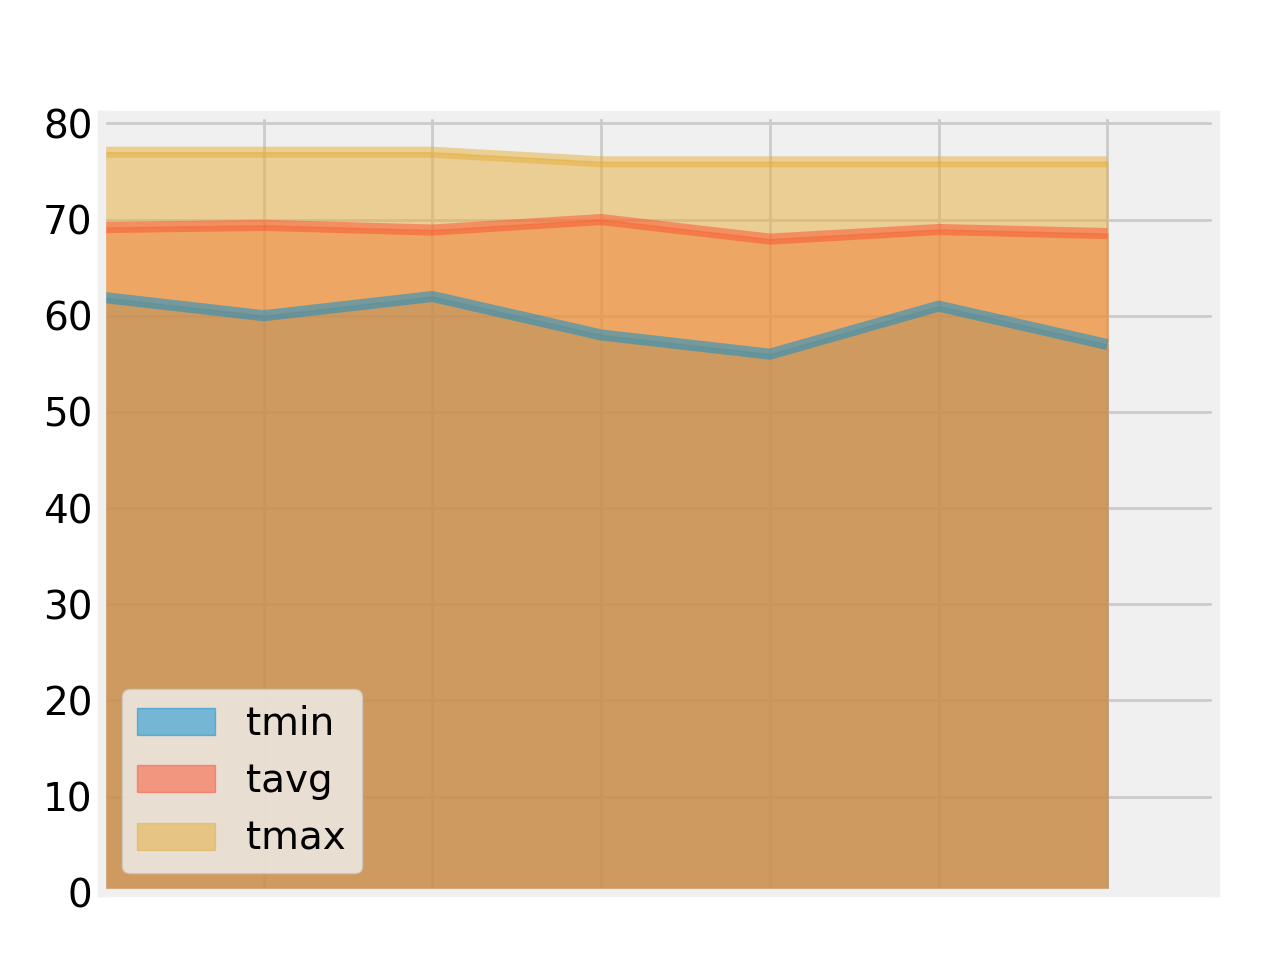

In [73]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False)